In [9]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *
import time

# geometric distribution for trials prob(n) = p q^(n-1) where p is success probability
F_geo = lambda x,p: np.floor(np.log(1-x)/np.log(1-p))
f = lambda x,p: p* (1-p)**(x-1)
# photon transmission probability in fiber (i.e., 0.2dB/km)
Trans = lambda x: 10**(-0.2*x/10)
# Binary Shanon entropy
def h(p_list):
    y_list = np.zeros(len(p_list))
    for i,p in enumerate(p_list):
        if p<1e-6 or (1-p)<1e-6:
            y_list[i]= 0
        else:
            y_list[i]= -p*np.log2(p)-(1-p)*np.log2(1-p)
    return y_list

# no cutoff
For reference

In [10]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware

def T_sequential_no_cutoff(τ_coh, mu_link, F_link,links):
    """ Calculate performance metrics for asynchronous sequential scheme using analytical formulas
    inputs:
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        links: list of segment (link) lengths in km
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    if type(links) != np.ndarray:
        links = np.array(links)
    τs = links/c
    T_tot = 2* np.sum( τs / (p_link*Trans(links)) )

    raw_rate = 1/T_tot
    N_links = len(links) # number of links, i.e. no. of repeaters + 1
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    f_memory_qkd = np.prod( p_link*Trans(links[1:])*np.exp(-4*τs[1:]/τ_coh)/(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    Le2e = np.sum(links)
    τe2e = Le2e/c
    f_memory_bell = np.exp(-3*τe2e/τ_coh) *np.prod(p_link*Trans(links[1:])*np.exp(-4*τs[1:]/τ_coh)/(1- (1-p_link*Trans(links[1:]))*np.exp(-4*τs[1:]/τ_coh) ) )
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4

    return raw_rate, skr, F_e2e


## with cutoff 

In [11]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware


def T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link,links):
    """ Calculate performance metrics for asynchronous sequential scheme using analytical formulas
    inputs:
        τ_cut: cut-off time
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        links: list of segment (link) lengths in km
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    if type(links) != np.ndarray:
        links = np.array(links)
    τs = links/c
    # implementing the recursion relation :
    ### Tn = Tn-1 / Pn + ( (1/Pn -1) τ_cut + Nm(ms[n],ps[n])*2*τs[n]/Pn)
    p1 = p_link*Trans(links[0])
    T_tot = 2*τs[0]/p1
    for i_l in np.arange(1,len(links)):
        L = links[i_l]
        m_n = int(τ_cut/(2*τs[i_l]))
        p_n = p_link*Trans(L)
        Nm = lambda x: (1-(1+m_n*x)*(1-x)**m_n)/x
        Pm = 1- (1-p_n)**m_n
        T_tot = T_tot / Pm +  (1/Pm -1)*τ_cut + Nm(p_n)*2*τs[i_l]/Pm

    raw_rate = 1/T_tot
    N_links = len(links) # number of links, i.e. no. of repeaters + 1
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    m_arr = np.floor(τ_cut/(2*τs))
    Pm_arr = 1- (1-p_link*Trans(links))**m_arr
    f_memory_qkd = np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-2*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    Le2e = np.sum(links)
    τe2e = Le2e/c
    f_memory_bell = np.exp(-3*τe2e/τ_coh) *np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-4*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-4*τs[1:]/τ_coh) )  )
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4

    # skr, F_e2e = 0, 0
    return raw_rate, skr, F_e2e


## rate vs. distance
uniform repeater chain

In [28]:
n = 8 # number of segments (i.e., no. of repeaters -1 )
τ_coh = 0.01
τ_cut = 1*τ_coh # cutoff
F_link = 1 # fidelity of local BP
mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)

Le2e_list = np.linspace(10,800,101) # e2e distance [km]
raw_rate_seq = np.zeros(len(Le2e_list))
skr_seq = np.zeros(len(Le2e_list))
Fe2e_seq = np.zeros(len(Le2e_list))
raw_rate_seq_no_cutoff = np.zeros(len(Le2e_list))
skr_seq_no_cutoff = np.zeros(len(Le2e_list))
Fe2e_seq_no_cutoff = np.zeros(len(Le2e_list))

for i, Le2e in enumerate(Le2e_list):
    Ls = [Le2e/n]*n
    raw_rate_seq[i], skr_seq[i], Fe2e_seq[i] = T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
    raw_rate_seq_no_cutoff[i], skr_seq_no_cutoff[i], Fe2e_seq_no_cutoff[i] = T_sequential_no_cutoff(τ_coh, mu_link, F_link, Ls)


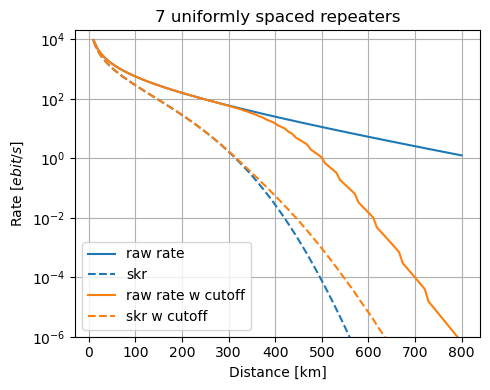

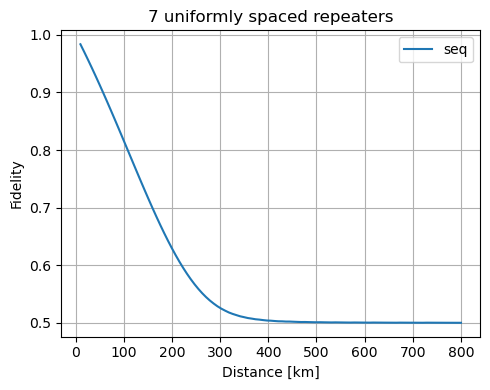

In [33]:
plt.figure(figsize=(5,4))
# plt.plot(Le2e_list,-np.log2(1-Trans(Le2e_list)),"k--", label="PLOB")
plt.plot(Le2e_list,raw_rate_seq_no_cutoff,"-",color="C0", label="raw rate")
plt.plot(Le2e_list,skr_seq_no_cutoff,"--",color="C0", label="skr")
plt.plot(Le2e_list,raw_rate_seq,"-",color="C1", label="raw rate w cutoff")
plt.plot(Le2e_list,skr_seq,"--",color="C1", label="skr w cutoff")
plt.yscale("log")
plt.xlabel("Distance [km]")
plt.ylabel(r"Rate $[ebit/s]$")
plt.ylim([1e-6,2e4])
plt.title(f"{n-1} uniformly spaced repeaters")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("figs/7_qr_cutoff_effect.pdf")
plt.show()


plt.figure(figsize=(5,4))
plt.plot(Le2e_list,Fe2e_seq,"-", label="seq")
plt.title(f"{n-1} uniformly spaced repeaters")
# plt.yscale("log")
plt.xlabel("Distance [km]")
# plt.ylabel(r"$T_{mem}/τ_{coh}$")
plt.ylabel("Fidelity")
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_fidelity_no_cutoff.pdf")
plt.show()


## Rate vs. cutoff time

In [6]:
Le2e = 400 # e2e distance [km]
n = 20 # number of segments (i.e., no. of repeaters -1 )
Ls = [Le2e/n]*n
τ_coh = 0.005 # coherence time [sec]
# τ_cut_list = np.linspace(0.1,1.0,200)*τ_coh # cutoff [sec]
# τ_cut_list = np.logspace(-1,1,200)*τ_coh # cutoff [sec]
τ_cut_list = np.logspace(-1,2,200)*Ls[0]/c # cutoff [sec]
F_link = 1 # fidelity of local BP
mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)

raw_rate_seq = np.zeros(len(τ_cut_list))
skr_seq = np.zeros(len(τ_cut_list))
Fe2e_seq = np.zeros(len(τ_cut_list))

for i_t, τ_cut in enumerate(τ_cut_list):
    raw_rate_seq[i_t], skr_seq[i_t], Fe2e_seq[i_t] = T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)


/tmp/ipykernel_1990538/391274565.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  T_tot = T_tot / Pm +  (1/Pm -1)*τ_cut + Nm(p_n)*2*τs[i_l]/Pm
/tmp/ipykernel_1990538/391274565.py:34: RuntimeWarning: invalid value encountered in scalar divide
  T_tot = T_tot / Pm +  (1/Pm -1)*τ_cut + Nm(p_n)*2*τs[i_l]/Pm
/tmp/ipykernel_1990538/391274565.py:42: RuntimeWarning: divide by zero encountered in divide
  f_memory_qkd = np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-2*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
/tmp/ipykernel_1990538/391274565.py:42: RuntimeWarning: invalid value encountered in multiply
  f_memory_qkd = np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-2*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
/tmp/ipykernel_1990538/3

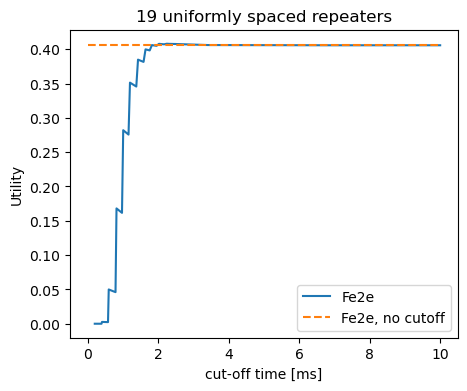

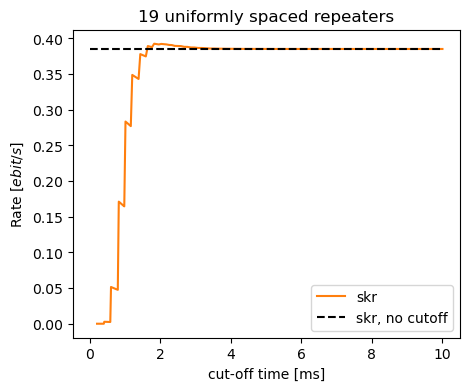

In [55]:
plt.figure(figsize=(5,4))

plt.plot(τ_cut_list*1e3,raw_rate_seq*(Fe2e_seq-0.5),"-",label="Fe2e")

# for reference:
raw_rate_seq_no_cut, skr_seq_no_cut, Fe2e_seq_no_cut = T_sequential_no_cutoff(τ_coh, mu_link, F_link, Ls)
plt.plot(τ_cut_list*1e3,raw_rate_seq_no_cut*(Fe2e_seq_no_cut-0.5)+0*τ_cut_list , "--",label="Fe2e, no cutoff")

plt.title(f"{n-1} uniformly spaced repeaters")
plt.ylabel(r"Utility")
plt.xlabel("cut-off time [ms]")
# plt.yscale("log")
plt.legend()
plt.show()

plt.figure(figsize=(5,4))

# plt.plot(τ_cut_list*1e3,raw_rate_seq,"-",color="C1",label="raw rate seq")
plt.plot(τ_cut_list*1e3,skr_seq,"-",color="C1",label="skr")

plt.plot(τ_cut_list*1e3,skr_seq_no_cut+0*τ_cut_list , "k--",label="skr, no cutoff")

plt.title(f"{n-1} uniformly spaced repeaters")
plt.ylabel(r"Rate $[ebit/s]$")
plt.xlabel("cut-off time [ms]")
plt.legend()
plt.show()


## optimal cutoff

In [12]:
n = 4 # number of segments (i.e., no. of repeaters -1 )
τ_coh_list = np.logspace(-4.3,-2,50) # coherence time [sec]
F_link = 1 # fidelity of local BP
mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)

Le2e_list = np.linspace(50,400,80)

num_τ = 200
raw_rate_seq = np.zeros((len(Le2e_list),len(τ_coh_list),num_τ))
skr_seq = np.zeros((len(Le2e_list),len(τ_coh_list),num_τ))
Fe2e_seq = np.zeros((len(Le2e_list),len(τ_coh_list),num_τ))

skr_seq_opt = np.zeros((len(Le2e_list),len(τ_coh_list)))
raw_rate_seq_opt = np.zeros((len(Le2e_list),len(τ_coh_list)))
Fe2e_seq_opt = np.zeros((len(Le2e_list),len(τ_coh_list)))
τ_cut_opt =  np.zeros((len(Le2e_list),len(τ_coh_list)))
skr_seq_no_cut =  np.zeros((len(Le2e_list),len(τ_coh_list)))

tic = time.time()
for i_L, Le2e in enumerate(Le2e_list):
    Ls = [Le2e/n]*n
    τ_cut_list = np.logspace(-0.5,2,num_τ)*Ls[0]/c/2 # cutoff [sec]
    
    print(i_L, end='\r')
    for i_coh, τ_coh in enumerate(τ_coh_list):
        for i_t, τ_cut in enumerate(τ_cut_list):
            raw_rate_seq[i_L,i_coh,i_t], skr_seq[i_L,i_coh,i_t], Fe2e_seq[i_L,i_coh,i_t] = T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
            if isnan(skr_seq[i_L,i_coh,i_t]):
                skr_seq[i_L,i_coh,i_t] = 0#1e-20

        idx = np.argmax(skr_seq[i_L,i_coh,:])
        # print(idx)
        # print(skr_seq[i_coh,:])
        skr_seq_opt[i_L,i_coh] = skr_seq[i_L,i_coh,idx]
        raw_rate_seq_opt[i_L,i_coh] = raw_rate_seq[i_L,i_coh,idx]
        Fe2e_seq_opt[i_L,i_coh] = Fe2e_seq[i_L,i_coh,idx]
        
        τ_cut_opt[i_L,i_coh] = τ_cut_list[idx]
        # raw_rate_seq_no_cut, skr_seq_no_cut[i_L,i_coh], _ = T_sequential_no_cutoff(τ_coh, mu_link, F_link, Ls)

out_dir = 'data_color_plot/'
fname = f"seq_n_{n}_mu_{mu_link}_F_{F_link}.npz"
np.savez(out_dir+fname, τ_coh_list, Le2e_list,
        raw_rate_seq, skr_seq, Fe2e_seq, 
        skr_seq_opt, raw_rate_seq_opt, Fe2e_seq_opt, τ_cut_opt)
toc = time.time()
print("Elapsed time: ", toc-tic)

/tmp/ipykernel_1991612/391274565.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  T_tot = T_tot / Pm +  (1/Pm -1)*τ_cut + Nm(p_n)*2*τs[i_l]/Pm
/tmp/ipykernel_1991612/391274565.py:34: RuntimeWarning: invalid value encountered in scalar divide
  T_tot = T_tot / Pm +  (1/Pm -1)*τ_cut + Nm(p_n)*2*τs[i_l]/Pm
/tmp/ipykernel_1991612/391274565.py:42: RuntimeWarning: divide by zero encountered in divide
  f_memory_qkd = np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-2*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
/tmp/ipykernel_1991612/391274565.py:42: RuntimeWarning: invalid value encountered in multiply
  f_memory_qkd = np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-2*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
/tmp/ipykernel_1991612/3

Elapsed time:  304.60084891319275


In [13]:
n = 4
F_link = 1 # fidelity of local BP
mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)

out_dir = 'data_color_plot/'
fname = f"seq_n_{n}_mu_{mu_link}_F_{F_link}.npz"


npz = np.load(out_dir+fname)
τ_coh_list = npz['arr_0']
Le2e_list = npz['arr_1']
raw_rate_seq = npz['arr_2']
skr_seq = npz['arr_3']
Fe2e_seq = npz['arr_4']
skr_seq_opt = npz['arr_5']
raw_rate_seq_opt = npz['arr_6']
Fe2e_seq_opt = npz['arr_7'] 
τ_cut_opt = npz['arr_8']


ValueError: x and y must have same first dimension, but have shapes (200,) and (50, 200)

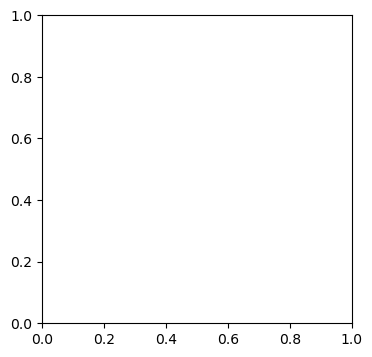

In [14]:
plt.figure(figsize=(4,4))

for i_coh, τ_coh in enumerate(τ_coh_list):
    plt.plot(τ_cut_list*1e3,skr_seq[i_coh,:],"-",color=f"C{i_coh}",label=f"{τ_coh:0.3f}")

plt.plot(τ_cut_list*1e3,skr_seq[-1,:],"-")

t0 = Ls[0]/c*1e3/Trans(Ls[0])
# plt.plot([t0,t0],[0,4],"k--")

# # for reference:
# plt.plot(τ_cut_list*1e3,raw_rate_par_no_cut+0*τ_cut_list , "-." ,color="C0",label="raw rate par, no cutoff")
# plt.plot(τ_cut_list*1e3,raw_rate_seq_no_cut+0*τ_cut_list , "-." ,color="C1",label="raw rate seq, no cutoff")
# plt.plot(τ_cut_list*1e3,skr_par_no_cut+0*τ_cut_list , ".", markersize=1 ,color="C0",label="skr par, no cutoff")
# plt.plot(τ_cut_list*1e3,skr_seq_no_cut+0*τ_cut_list , ".", markersize=1 ,color="C1",label="skr seq, no cutoff")

plt.ylabel(r"Rate $[ebit/s]$")
plt.xlabel("cut-off time [ms]")
plt.yscale("log")
plt.legend()
plt.show()


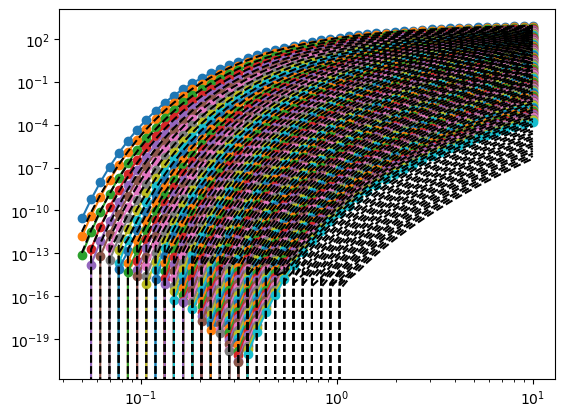

In [15]:
skr_seq_no_cut =  np.zeros((len(Le2e_list),len(τ_coh_list)))

for i_L, Le2e in enumerate(Le2e_list):
    Ls = [Le2e/n]*n
    for i_coh, τ_coh in enumerate(τ_coh_list):
        raw_rate_seq_no_cut, skr_seq_no_cut[i_L,i_coh], _ = T_sequential_no_cutoff(τ_coh, mu_link, F_link, Ls)

# plt.plot(τ_coh_list*1e3, τ_cut_opt.T*1e3,"o-")
plt.plot(τ_coh_list*1e3, skr_seq_opt.T,"o-")
plt.plot(τ_coh_list*1e3, skr_seq_no_cut.T,"k--")
plt.yscale('log')
plt.xscale('log')
# skr_seq_opt

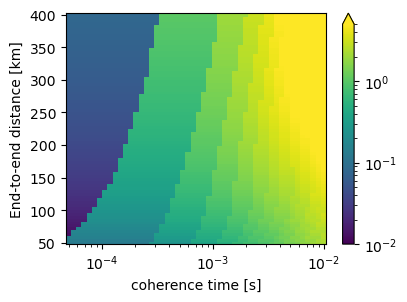

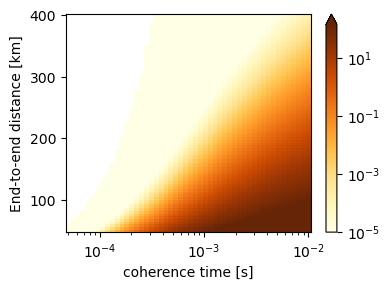

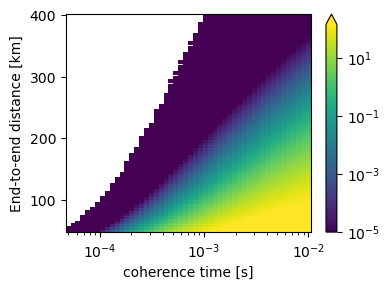

In [16]:
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors
from matplotlib.ticker import LinearLocator

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X, Y = np.meshgrid(τ_coh_list, Le2e_list)
# Z = skr_seq_opt
# # Plot the surface.
# surf = ax.plot_surface(X, Y, skr_seq_no_cut, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

# ax.view_init(azim=0, elev=90)
# plt.pcolor(X, Y, np.log(skr_seq_no_cut), cmap='viridis', vmin=1e-5, vmax=5)

plt.figure(figsize=(4.2,3))

Z = τ_cut_opt*1e3
pcm = plt.pcolor(X, Y, Z,norm=colors.LogNorm(vmin=1e-2, vmax=5),
                   cmap='viridis', shading='auto')
plt.colorbar(pcm, extend='max')
# plt.colorbar()
plt.ylabel("End-to-end distance [km]")
plt.xlabel("coherence time [s]")
plt.xscale("log")

plt.figure(figsize=(4,3))
Z = skr_seq_opt
pcm = plt.pcolor(X, Y, Z,norm=colors.LogNorm(vmin=1e-5, vmax=150),
                   cmap='YlOrBr', shading='auto')
plt.colorbar(pcm, extend='max')
# plt.colorbar()
plt.xscale("log")
plt.ylabel("End-to-end distance [km]")
plt.xlabel("coherence time [s]")
plt.tight_layout()
fig_dir = "min_protocol_figs/"
fname = f"seq_n_{n}_mu_{mu_link}_F_{F_link}.png"
plt.savefig(fig_dir+ fname, dpi=300)

plt.figure(figsize=(4,3))
Z = skr_seq_no_cut
pcm = plt.pcolor(X, Y, Z,norm=colors.LogNorm(vmin=1e-5, vmax=150),
                   cmap='viridis', shading='auto')
plt.colorbar(pcm, extend='max')
# plt.colorbar()
plt.xscale("log")
plt.ylabel("End-to-end distance [km]")
plt.xlabel("coherence time [s]")
plt.tight_layout()

# plt.figure()
# plt.pcolor(X, Y, np.log(skr_seq_opt), cmap='viridis', vmin=-1e-5, vmax=5)
# plt.colorbar()
# plt.xscale("log")
# plt.zscale("log")


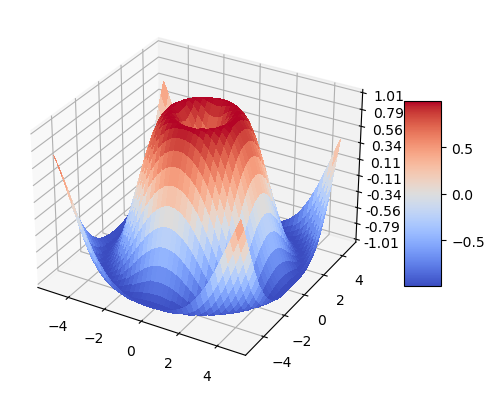

In [62]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()